In [24]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import cirq 
import cirq_google
import qsimcirq

from circuits import *
from utils import *

import matplotlib.pyplot as plt

In [25]:
processor_id = "willow_pink"
device = cirq_google.engine.create_device_from_processor_id(processor_id)
gateset = device.metadata.compilation_target_gatesets[0]
connectivity_graph = device.metadata.nx_graph

noise_props = cirq_google.engine.load_device_noise_properties(processor_id)
noise_model = cirq_google.NoiseModelFromGoogleNoiseProperties(noise_props)
sim = qsimcirq.QSimSimulator(noise=noise_model)
cal = cirq_google.engine.load_median_device_calibration(processor_id)
sim_processor = cirq_google.engine.SimulatedLocalProcessor(
    processor_id=processor_id, sampler=sim, device=device, calibrations={cal.timestamp // 1000: cal})
sim_engine = cirq_google.engine.SimulatedLocalEngine([sim_processor])

In [32]:
A = [cirq.GridQubit(5,9), cirq.GridQubit(6,9)]
B = [cirq.GridQubit(5,10), cirq.GridQubit(6,10)]

# 1) Prepare fiducial in A (system) and fiducial in B (ancilla).
# 2) Apply controlled shift (A: target, B: control)
# 3) Inverse fourier transform B. This implements the operator D.
# 4) Measuring in computational basis realize the WH-POVM.
circuit = cirq.Circuit((d4_fiducial(A),\
                        d4_fiducial(B, conjugate=True),\
                        CXdag(B, A),\
                        Fdag(B),\
                        cirq.measure(*(A+B),key="result")))
optimized_circuit = cirq.optimize_for_target_gateset(cirq.RouteCQC(connectivity_graph)(circuit),\
                                                     context=cirq.TransformerContext(deep=True), gateset=gateset)
device.validate_circuit(optimized_circuit)
print(optimized_circuit)

(3, 7): ───PhX(0.0405)^0.579───@───PhX(-0.307)^0.5─────@───PhXZ(a=0.301,x=0.755,z=-0.456)──────────────────────────────────────────────────────────────────────────────────────@─────────────────────────────────────────PhXZ(a=0.5,x=0.5,z=0)──────────@───PhX(-0.5)^0.5──────@───PhX(0.5)^0.5─────────────────────────────────────────────────────────────────PhXZ(a=-1.0,x=0.75,z=0)──────────@───PhX(8.88e-16)^0.5───@───PhX(-1.0)^0.5────@───PhXZ(a=-0.5,x=0.5,z=1.0)─────M─────────────
                               │                       │                                                                                                                       │                                                                        │                      │                                                                                                                 │                       │                    │                                │
(4, 7): ───PhX(-0.429)^0.109───@───PhX(-0.496)^0.5─────@─

In [33]:
# Realistic simulation
N = 50000
samples = sim_engine.get_sampler(processor_id).run(optimized_circuit, repetitions=N)
counts = samples.histogram(key="result")

# To compare this side by side with the AK result, we reorder the probabilities to reflect that
# we've changed convention from D^\dag \Pi D to D \Pi D^\dag
noisy_freqs = change_conjugate_convention(np.array([v for k, v in sorted(counts.items())])/N)
noisy_freqs

array([0.221, 0.05 , 0.057, 0.063, 0.052, 0.026, 0.022, 0.054, 0.09 ,
       0.041, 0.066, 0.039, 0.051, 0.066, 0.051, 0.051])

In [35]:
# Exact simulation 
s = cirq.Simulator()
samples = s.run(circuit, repetitions=N)
counts = samples.histogram(key="result")
exact_freqs = change_conjugate_convention(np.array([v for k, v in sorted(counts.items())])/N)
exact_freqs

array([0.252, 0.049, 0.051, 0.049, 0.051, 0.05 , 0.051, 0.051, 0.049,
       0.047, 0.049, 0.05 , 0.051, 0.049, 0.051, 0.049])

In [36]:
# Direct calculation
d = 4
phi = d4_fiducial_ket()
Pi = np.outer(phi, phi.conj())
E = wh_povm(phi)
p = np.array([(e@Pi).trace() for e in E]).real; p

array([0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05])

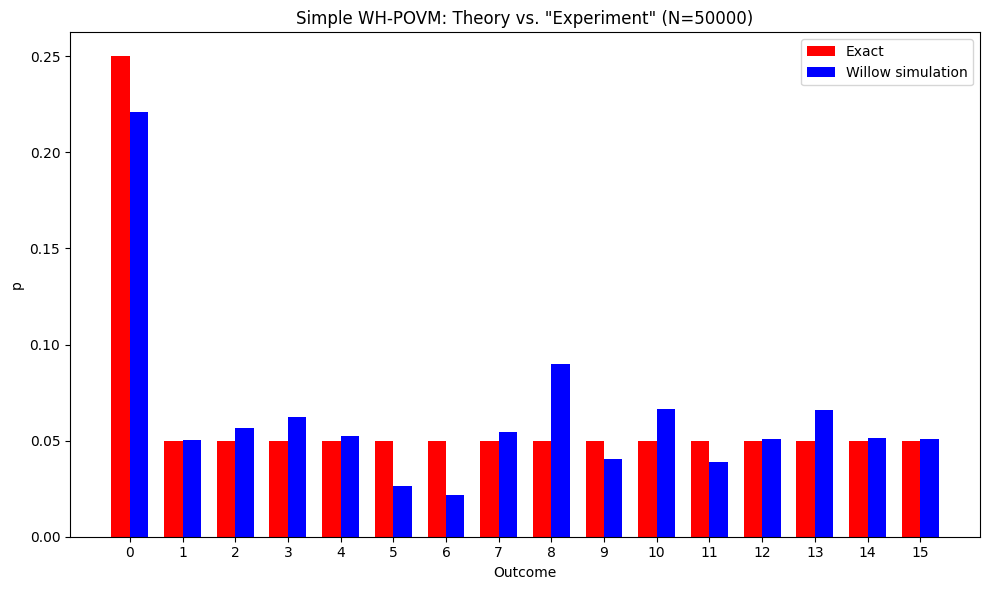

In [37]:
x_pos = np.arange(2**4) 
bar_width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x_pos - bar_width/2, p, width=bar_width, label='Exact', color='red')
plt.bar(x_pos + bar_width/2, noisy_freqs, width=bar_width, label='Willow simulation', color='blue')
plt.ylabel('p')
plt.xlabel('Outcome')
plt.title('Simple WH-POVM: Theory vs. "Experiment" (N=%d)' % N)
plt.xticks(x_pos)
plt.legend()
plt.tight_layout()

In [ ]:
get_gate_counts(circuit)

--- Gate Counts (by type) ---
Ry: 10
_PauliX: 4
CXPowGate: 12
ZPowGate: 6
HPowGate: 8
CZPowGate: 9
SwapPowGate: 3
MeasurementGate: 1


In [ ]:
get_gate_counts(optimized_circuit)

--- Gate Counts (by type) ---
PhasedXPowGate: 31
CZPowGate: 23
PhasedXZGate: 21
MeasurementGate: 1
